Input
* gene signatures
* peak signatures <-- unique to this TF-Region-TG notebook
* Constructed Scenicpluc network
* adata with gene expression data

What this notebook does
* Get expressing genes with a threshold set
* Construct TF-TG network
    - Target gene: genes of interest
    - all TFs need to be "expressed genes"
    - TFs which indirectly target the "target genes" are also included (TF -> TF -> Target gene)
    - For each interaction (TF - Region - Gene), <u>either TF or Redion need to be "signature"</u> of the cell population of interest
* Calculate metrices
    - Centrality
    - Number of targeted gene signatures
    - Number of marker genes (for reference)

In [1]:
# Parameters
working_dir = "/nfs/team205/heart/Vitro/TF_selection/foetal_SANPcell_vs_workingCM"
path_to_adata_gex = "/nfs/team205/heart/anndata_objects/Foetal/Feb28ObjectRaw_Multiome.h5ad"
path_to_adata_peak_tfidf = "/nfs/team205/heart/anndata_objects/Foetal/multiome_ATAC/ArchR/project_output/PeakMatrix/Foetal_Peaks_tfidf.h5ad"
path_to_DAR_1 = "/nfs/team205/heart/anndata_objects/Foetal/multiome_ATAC/ArchR/project_output/MarkerPeaks/SANP-vs-aCM.csv"
path_to_DAR_2 = "/nfs/team205/heart/anndata_objects/Foetal/multiome_ATAC/ArchR/project_output/MarkerPeaks/aCM-vs-SANP.csv"
path_to_p2g_ArchR = ""
group_key = "fine_grain_aCMs_merged"
group_a = "SinoatrialNodeCardiomyocytes"
group_b = "AtrialCardiomyocytes"
subset_object = True
geneset_list = ["MSigDB_Hallmark_2020", "KEGG_2021_Human", "GO_Biological_Process_2023"]

path_to_eRegulon_signatures_gene = "/nfs/team205/heart/pyscenic/plus/eRegulon_signatures/Cardiomyocytes_Gene_eRegulon_signatures.pkl"
path_to_eRegulon_signatures_region = "/nfs/team205/heart/pyscenic/plus/eRegulon_signatures/Cardiomyocytes_Region_eRegulon_signatures.pkl"

path_to_gene_signatures='/nfs/team205/heart/Vitro/TF_selection/foetal_SANPcell_vs_workingCM/outs/gene_signatures.pkl'
path_to_peak_signatures='/nfs/team205/heart/Vitro/TF_selection/foetal_SANPcell_vs_workingCM/outs/peak_signatures.pkl'

path_to_eRegulon_metadata = "/nfs/team205/heart/pyscenic/plus/eRegulon_metadata/Cardiomyocytes_eRegulon_metadata_filtered.csv" # filtered metadata

###### parameters for TF selection for the population ######
cell_of_intest = 'SinoatrialNodeCardiomyocytes'
groups_for_signatures = ['SinoatrialNodeCardiomyocytes']

# proportion threshold for expressing genes
exp_prop_thresh = 0.1

# proportion threshold for accesible regions
access_prop_thresh = 0.01

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata

import matplotlib.pyplot as plt
import matplotlib as mpl
# enables correct plotting of text
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42 
import seaborn as sns

# import hotspot

In [3]:
import session_info
session_info.show()

In [4]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/regulon_plot.py")
regulon_plot = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = regulon_plot
spec.loader.exec_module(regulon_plot)

In [5]:
sc.settings.set_figure_params(dpi=80,dpi_save=300)

In [6]:
figdir = '/nfs/team205/heart/fetal_ms_figures/raw_plots_kk'

# 1. Read in inputs

## Read in and prepare anndata contains gene expression

In [7]:
# read in adata
# whole data
adata = sc.read_h5ad(path_to_adata_gex)

# filter and log-normalise
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

print(adata.X.data[:10])
adata

[0.41374123 0.22811745 0.22811745 0.41374123 0.22811745 0.41374123
 0.22811745 0.41374123 0.22811745 0.22811745]


AnnData object with n_obs × n_vars = 211145 × 34377
    obs: 'sangerID', 'combinedID', 'donor', 'region', 'age', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet', 'batch_key', '_scvi_batch', 'FACSgate', 'fine_grain', 'mid_grain', 'coarse_grain', 'sex', 'week', 'trimester', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', '_scvi_labels', 'stress_score', 'hb1_score', 'fine_grain_aCMs_merged', 'fine_grain_aCMs-node_merged'
    var: 'gene_id', 'n_cells'
    uns: 'log1p'

## Read in peak signatures

In [8]:
peak_signatures = utils.read_pkl(path_to_peak_signatures)
peak_signatures.keys()

dict_keys(['SinoatrialNodeCardiomyocytes_up', 'SinoatrialNodeCardiomyocytes_down'])

In [9]:
sig_peaks = peak_signatures['SinoatrialNodeCardiomyocytes_up']
print(len(sig_peaks))
sig_peaks[:5]

2197


['chr1:55555893_55556393',
 'chr12:115794713_115795213',
 'chr3:113167147_113167647',
 'chr17:65228782_65229282',
 'chr11:116485972_116486472']

## Read in scenicplus output metadata

In [10]:
# scenicplus output
scenic_meta = pd.read_csv(path_to_eRegulon_metadata,index_col=0)
scenic_meta['Region'] = [x.replace('-','_') for x in scenic_meta['Region']]

# select active regulons
scenic_meta = scenic_meta[['_+_' in x for x in scenic_meta['Gene_signature_name']]]
scenic_meta.head()

,Region_signature_name,Gene_signature_name,TF,is_extended,Region,Gene,R2G_importance,R2G_rho,R2G_importance_x_rho,R2G_importance_x_abs_rho,TF2G_importance,TF2G_regulation,TF2G_rho,TF2G_importance_x_abs_rho,TF2G_importance_x_rho,Consensus_name
0,ARID3A_+_(2626r),ARID3A_+_(1426g),ARID3A,False,chr9:133429494_133429994,SLC2A6,0.053716,0.071594,0.003846,0.003846,1.136288,1,0.194652,0.221181,0.221181,ARID3A_+_+
1,ARID3A_+_(2626r),ARID3A_+_(1426g),ARID3A,False,chr9:133532968_133533468,SLC2A6,0.008413,0.058097,0.000489,0.000489,1.136288,1,0.194652,0.221181,0.221181,ARID3A_+_+
2,ARID3A_+_(2626r),ARID3A_+_(1426g),ARID3A,False,chr15:74322487_74322987,CYP11A1,0.017410,0.170724,0.002972,0.002972,1.467521,1,0.447985,0.657428,0.657428,ARID3A_+_+
3,ARID3A_+_(2626r),ARID3A_+_(1426g),ARID3A,False,chr15:74490018_74490518,CYP11A1,0.034692,0.167948,0.005826,0.005826,1.467521,1,0.447985,0.657428,0.657428,ARID3A_+_+
4,ARID3A_+_(2626r),ARID3A_+_(1426g),ARID3A,False,chr15:74302765_74303265,CYP11A1,0.047807,0.197330,0.009434,0.009434,1.467521,1,0.447985,0.657428,0.657428,ARID3A_+_+


In [11]:
# select based on R2G_rho
rho_thresh = 0.2
scenic_meta = scenic_meta[scenic_meta['R2G_rho']>rho_thresh]

# 2. DEG: SANCM vs other CMs

/nfs/team205/kk18/miniconda3/envs/vitro/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


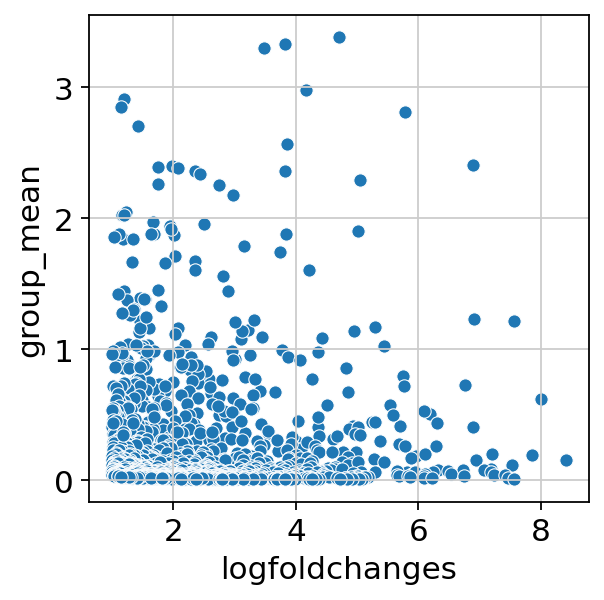

In [12]:
logFC_threshold = 1
group_mean_threshold = 0.1

adata_sub = adata[adata.obs['coarse_grain']=='Cardiomyocytes']
adata_sub = adata_sub[adata_sub.obs['kit_10x']=='Multiome-v1']

res = utils.rank_genes_groups_with_mean(adata_sub,
                                 groupby = 'fine_grain',
                                  groups = ['SinoatrialNodeCardiomyocytes'],
                                  reference = 'rest',
                                  method = 't-test',
                                  pval_cutoff = 0.05,
                                        log2fc_min=logFC_threshold
                                 )
sns.scatterplot(x=res['logfoldchanges'],y=res['group_mean'])
plt.show()

In [13]:
# filter genes based on the group mean expression
res = res[res['group_mean']>group_mean_threshold]
display(res.head())
degs_sancm_vs_others = list(res['names'])
len(degs_sancm_vs_others)

,names,scores,logfoldchanges,pvals,pvals_adj,group,group_mean
0,PLCB1,84.671532,4.711341,0.000000e+00,0.000000e+00,SinoatrialNodeCardiomyocytes,3.381570
1,ZNF385B,69.013870,4.159338,0.000000e+00,0.000000e+00,SinoatrialNodeCardiomyocytes,2.982164
2,MYH6,65.799339,3.481761,0.000000e+00,0.000000e+00,SinoatrialNodeCardiomyocytes,3.303232
3,CACNA1D,58.238865,5.785079,7.879209e-297,1.103148e-293,SinoatrialNodeCardiomyocytes,2.811245
4,RGS6,57.740051,3.851809,8.022425e-297,1.103148e-293,SinoatrialNodeCardiomyocytes,2.566191


675

In [14]:
sig_genes = degs_sancm_vs_others.copy()

In [15]:
'ISL1' in sig_genes

True

# 3. DEG: Foetal vs Adult

## Read in adult anndata and concatenate with foetal data

In [16]:
# prepare adult anndata
adata_adult = sc.read_h5ad('/nfs/team205/heart/anndata_objects/8regions/RNA_adult-8reg_full_raw_cellstate-annotated.h5ad')

# subset SAN_P_cell
adata_adult = adata_adult[adata_adult.obs['cell_state']=='SAN_P_cell']
adata_adult = adata_adult[adata_adult.obs['kit_10x']=='Multiome-v1']

# log normalise
sc.pp.normalize_total(adata_adult, target_sum=1e4)
sc.pp.log1p(adata_adult)
print(adata_adult.X.data[:10])

# rename
adata_adult.var['gene_id'] =  adata_adult.var_names.copy()
adata_adult.var.set_index('gene_name-new',inplace=True)
adata_adult.var_names = adata_adult.var_names.astype('str')
adata_adult.var_names_make_unique()

adata_adult

[0.911473   0.31626672 0.31626672 0.31626672 0.74952203 0.911473
 0.31626672 0.31626672 0.31626672 0.31626672]


/nfs/team205/kk18/miniconda3/envs/vitro/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 245 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'n_counts', '_scvi_batch', '_scvi_labels', 'clus20', 'doublet_cls', 'original_or_new', 'batch', 'scANVI_predictions', 'leiden_scArches'
    var: 'gene_name_scRNA-0-original', 'gene_name_snRNA-1-original', 'gene_name_multiome-2-original', 'gene_id'
    uns: 'age_colors', 'cell_or_nuclei_colors', 'cell_state_colors', 'cell_type_colors', 'donor_colors', 'donor_type_color

In [17]:
# concatenate
## shared features
shared = list(set(adata_sub.var_names).intersection(adata_adult.var_names))

adata_sub.obs['stage'] = 'foetal'
adata_adult.obs['stage'] = 'adult'
adata_adult.obs['week'] = 'adult'
adata_adult.obs['fine_grain'] = 'adult - SAN_P_cell'

adata_conc = adata_sub[:,shared].concatenate(adata_adult[:,shared],
                                             join='inner',
                                             batch_key=None,
                                             index_unique=None
                                            )

/nfs/team205/kk18/miniconda3/envs/vitro/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [18]:
# combine donor and stage key
adata_conc.obs['donor_new'] = adata_conc.obs['stage'].astype('str')+'_'+adata_conc.obs['donor'].astype('str')
set(adata_conc.obs['donor_new'])

{'adult_A61',
 'adult_AH1',
 'adult_AH2',
 'adult_AV10',
 'adult_AV14',
 'adult_AV3',
 'foetal_C104',
 'foetal_C82',
 'foetal_C85',
 'foetal_C87',
 'foetal_C92',
 'foetal_C98',
 'foetal_Hst33',
 'foetal_Hst36',
 'foetal_Hst39',
 'foetal_Hst40',
 'foetal_Hst41'}

## Prepare anndata for pseudobulk wilcoxon test

In [19]:
# add drimester 
donor_trimester_df = adata_conc.obs[['donor','trimester']].copy()
donor_trimester_df = donor_trimester_df.drop_duplicates()
donor_trimester_df['trimester'] = [x if x==x else 'adult' for x in donor_trimester_df['trimester']]
donor_trimester_df

,donor,trimester
barcode,,
BHF_F_Hea11064670_BHF_F_Hea11031823_TTGCTTAGTGAGACTC-1,C82,firsttrimester
BHF_F_Hea11064671_BHF_F_Hea11031824_GTATCGCCACCTCACC-1,C85,firsttrimester
BHF_F_Hea11064672_BHF_F_Hea11031825_GTCGAAGCATGAGTTT-1,C87,firsttrimester
BHF_F_Hea11933666_BHF_F_Hea11596619_TGATGACTCGCTAAGT-1,Hst33,secondtrimester
BHF_F_Hea11933670_BHF_F_Hea11596623_GAGCTAGCAAACGGGC-1,C92,firsttrimester
BHF_F_Hea11933674_BHF_F_Hea11596627_CTTAACAAGAGGCTAA-1,C98,firsttrimester
BHF_F_Hea13188317_BHF_F_Hea13187619_AGCTAACTCTATCGCC-1,Hst41,secondtrimester
BHF_F_Hea13188328_BHF_F_Hea13187630_GCAATGTTCTAAGGTC-1,C104,firsttrimester
7089STDY13216920_BHF_F_Hea13242527_GTCTTTGTCCCTTGCG-1,Hst40,secondtrimester


In [20]:
groupby = 'donor_new'
celltypes = ['SinoatrialNodeCardiomyocytes','adult - SAN_P_cell']
n_cell_thresh = 10

# subset anndata
ad = adata_conc[adata_conc.obs['fine_grain'].isin(celltypes)]
# remove group which only has less than a threshold
vc = ad.obs[groupby].value_counts()
grp_to_drop = list(vc.index[vc < 10])
ad = ad[~ad.obs[groupby].isin(grp_to_drop)]
print(f'dropped groups: {grp_to_drop}')

# mean expression per group
exp_mean = utils.grouped_obs_mean(ad, group_key=groupby)

# make anndata
import anndata
adata_pb = anndata.AnnData(
    X=exp_mean.T,
    obs=pd.DataFrame(exp_mean.columns).set_index(0),
    var=pd.DataFrame(exp_mean.index).set_index(0)
)

# add stage key
adata_pb.obs['stage'] = [x.split('_')[0] for x in adata_pb.obs_names]
adata_pb.obs['stage'] = adata_pb.obs['stage'].astype('category')
adata_pb.obs['stage'].cat.reorder_categories(['foetal','adult'],inplace=True)

# add donor and trimester key
adata_pb.obs['donor'] = [x.split('_')[1] for x in adata_pb.obs_names]
obs = adata_pb.obs.reset_index().merge(donor_trimester_df,how='left',on='donor').set_index(0)
obs.index.name = 'index'
adata_pb.obs = obs
adata_pb.obs['trimester'] = adata_pb.obs['trimester'].astype('category')
adata_pb.obs['trimester'].cat.reorder_categories(['firsttrimester','secondtrimester','adult'],inplace=True)


print(adata_pb.obs['stage'].value_counts())
print(adata_pb)

dropped groups: ['foetal_C82', 'foetal_Hst36']
foetal    8
adult     6
Name: stage, dtype: int64
AnnData object with n_obs × n_vars = 14 × 30749
    obs: 'stage', 'donor', 'trimester'


/tmp/ipykernel_58626/3068665136.py:27: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata_pb.obs['stage'].cat.reorder_categories(['foetal','adult'],inplace=True)
/tmp/ipykernel_58626/3068665136.py:35: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata_pb.obs['trimester'].cat.reorder_categories(['firsttrimester','secondtrimester','adult'],inplace=True)


## Pseudobulk wilcoxon test

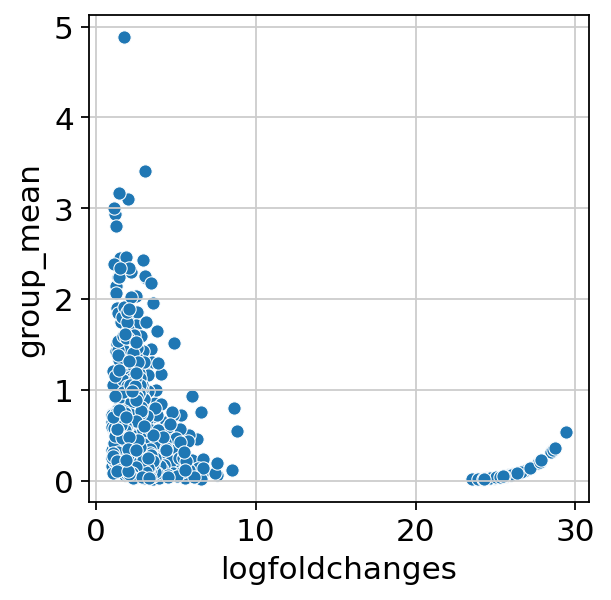

In [21]:
# rank test
logFC_threshold_FvsA = 1
group_mean_threshold = 0.1

res_foetal_vs_adult = utils.rank_genes_groups_with_mean(adata_pb,
                                 groupby = 'stage',
                                  groups = ['foetal'],
                                  reference = 'adult',
                                  method = 'wilcoxon',
                                  pval_cutoff = 0.1,
                                        log2fc_min=logFC_threshold_FvsA
                                 )

sns.scatterplot(x=res_foetal_vs_adult['logfoldchanges'],y=res_foetal_vs_adult['group_mean'])
plt.show()

In [22]:
res_foetal_vs_adult = res_foetal_vs_adult[res_foetal_vs_adult['group_mean']>group_mean_threshold]
degs_foetal_vs_adult = list(res_foetal_vs_adult['names'])
print(len(degs_foetal_vs_adult))
display(res_foetal_vs_adult.head())

620


,names,scores,logfoldchanges,pvals,pvals_adj,group,group_mean
0,HBA1,3.098387,4.578313,0.001946,0.052668,foetal,0.232496
1,PTPRD,3.098387,2.550217,0.001946,0.052668,foetal,1.853987
4,TRPC3,3.098387,3.426268,0.001946,0.052668,foetal,0.111293
5,SMC4,3.098387,1.721522,0.001946,0.052668,foetal,0.288116
6,ARHGAP6,3.098387,2.758113,0.001946,0.052668,foetal,0.204842


In [23]:
res_foetal_vs_adult[res_foetal_vs_adult['names']=='CACNA1D']

,names,scores,logfoldchanges,pvals,pvals_adj,group,group_mean


In [24]:
len(degs_foetal_vs_adult)

620

# 4. Obtain expressing genes and accessible regions

## Genes

In [25]:
# get expression proportions
exp_mat = utils.get_exp_proportion(adata,groupby='fine_grain', use_rep='X')
exp_genes = list(exp_mat.index[exp_mat[cell_of_intest]>exp_prop_thresh])
len(exp_genes)

6813

In [26]:
'ISL1' in exp_genes

True

## Peaks

In [27]:
adata_peak = sc.read_h5ad(path_to_adata_peak_tfidf)
adata_peak

AnnData object with n_obs × n_vars = 167022 × 508040
    obs: 'sangerID', 'combinedID', 'donor', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'multiplexed', 'batch_key', 'region', 'FACSgate', 'sex', 'week', 'trimester', 'fine_grain', 'mid_grain', 'coarse_grain', 'heart_or_greatvessels'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'distToGeneStart', 'nearestGene', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N'

In [28]:
# get accessible proportions
access_mat = utils.get_exp_proportion(adata_peak,groupby='fine_grain', use_rep='X')

In [29]:
access_peaks = list(access_mat.index[access_mat[cell_of_intest]>access_prop_thresh])
len(access_peaks)

183387

# Prepare scenic metadata

In [30]:
# add columns to scenicplus metadata
# scenic_meta['Gene_isTF'] = scenic_meta['Gene'].isin(list(set(scenic_meta['TF'])))
scenic_meta['TF_isExp'] = scenic_meta['TF'].isin(exp_genes)
scenic_meta['TF_isSignature'] = (scenic_meta['TF'].isin(sig_genes))&(scenic_meta['TF'].isin(exp_genes))
scenic_meta['Region_isAccess'] = scenic_meta['Region'].isin(access_peaks)
scenic_meta['Region_isSignature'] = (scenic_meta['Region'].isin(sig_peaks))&(scenic_meta['Region'].isin(access_peaks))
scenic_meta.head()

,Region_signature_name,Gene_signature_name,TF,is_extended,Region,Gene,R2G_importance,R2G_rho,R2G_importance_x_rho,R2G_importance_x_abs_rho,TF2G_importance,TF2G_regulation,TF2G_rho,TF2G_importance_x_abs_rho,TF2G_importance_x_rho,Consensus_name,TF_isExp,TF_isSignature,Region_isAccess,Region_isSignature
6,ARID3A_+_(2626r),ARID3A_+_(1426g),ARID3A,False,chrX:107672788_107673288,TSC22D3,0.030871,0.359082,0.011085,0.011085,4.238257,1,0.620499,2.629833,2.629833,ARID3A_+_+,True,False,True,False
21,ARID3A_+_(2626r),ARID3A_+_(1426g),ARID3A,False,chr16:85564640_85565140,GINS2,0.034553,0.242701,0.008386,0.008386,5.814786,1,0.648615,3.771556,3.771556,ARID3A_+_+,True,False,True,False
22,ARID3A_+_(2626r),ARID3A_+_(1426g),ARID3A,False,chr16:85819120_85819620,GINS2,0.045041,0.210842,0.009497,0.009497,5.814786,1,0.648615,3.771556,3.771556,ARID3A_+_+,True,False,False,False
23,ARID3A_+_(2626r),ARID3A_+_(1426g),ARID3A,False,chr16:85566734_85567234,GINS2,0.003632,0.260465,0.000946,0.000946,5.814786,1,0.648615,3.771556,3.771556,ARID3A_+_+,True,False,True,False
24,ARID3A_+_(2626r),ARID3A_+_(1426g),ARID3A,False,chr16:85718685_85719185,GINS2,0.002332,0.241409,0.000563,0.000563,5.814786,1,0.648615,3.771556,3.771556,ARID3A_+_+,True,False,False,False


# Select interactions

In [31]:
target_genes = ['SEMA3A', 'SLIT2', 'SLIT3', 'EFNB2', 'CXCL12', 'FGF10', 'VEGFC', 'NELL1']
# based on the previous analysis

In [32]:
# select interactions

# select interaction which target "target_genes"
scenic_meta_sel = scenic_meta[(scenic_meta['Gene'].isin(target_genes))&\
                               scenic_meta['TF_isExp'] &\
                               scenic_meta['Region_isAccess'] &\
                              (scenic_meta['TF_isSignature']|scenic_meta['Region_isSignature'])
                             ]

# get TFs and target genes in the selected interaction
direct_TFs = list(set(scenic_meta_sel['TF']))
targets = list(set(scenic_meta_sel['Gene']))
# remove TFs already in target genes
TFs_sel = list(set(direct_TFs) - set(targets))

print(len(TFs_sel))
print(f'direct TFs: {direct_TFs}')
print('')

# select higher level interactions 
print('Start looking for higher level TFs')
higher_level_TFs = []
while len(TFs_sel)>0:
    scenic_meta_sel2 = scenic_meta[(scenic_meta['Gene'].isin(TFs_sel))&\
                               scenic_meta['TF_isExp'] &\
                               scenic_meta['Region_isAccess'] &\
                              (scenic_meta['TF_isSignature']|scenic_meta['Region_isSignature'])
                                  ]
    higher_level_TFs = higher_level_TFs + list(set(scenic_meta_sel2['TF']))
    if len(scenic_meta_sel2)>0:
        # concatenate
        scenic_meta_sel = pd.concat([scenic_meta_sel,scenic_meta_sel2])
        scenic_meta_sel = scenic_meta_sel.drop_duplicates()
        # get TFs and target genes in the selected interaction
        TFs_sel = list(set(scenic_meta_sel['TF']))
        targets = list(set(scenic_meta_sel['Gene']))
        # remove TFs already in target genes
        TFs_sel = list(set(TFs_sel) - set(targets))
        print(f'{len(TFs_sel)}: {TFs_sel}')
    else:
        print('no more higher level TFs')
        TFs_sel = []

scenic_meta_sel['direct_TF'] = scenic_meta_sel['TF'].isin(direct_TFs)
higher_level_TFs = list(set(higher_level_TFs)-set(direct_TFs))

# reindex
scenic_meta_sel.index = range(len(scenic_meta_sel))

print("")
print(f'Number of selected interactions: {len(scenic_meta_sel)}')
print(f"Number of TFs: {len(set(scenic_meta_sel['TF']))}")

14
direct TFs: ['SMAD9', 'MEF2C', 'BNC2', 'NR2F1', 'NFIB', 'PKNOX2', 'THRB', 'HMGA2', 'TBX5', 'POU6F2', 'NR2F2', 'FOS', 'TRPS1', 'TBX18']

Start looking for higher level TFs
11: ['RARB', 'NFIA', 'SHOX2', 'TBX3', 'JUN', 'NFIB', 'ZNF41', 'MAX', 'ETV6', 'MITF', 'ISL1']
13: ['KLF13', 'ZNF529', 'FOXO1', 'NFIB', 'JUN', 'GLIS3', 'ZNF41', 'MAX', 'TEAD1', 'MEIS1', 'SP4', 'TEAD3', 'BHLHE40']
10: ['KLF13', 'ZNF529', 'NFIB', 'JUN', 'ZNF41', 'MAX', 'TEAD1', 'TEAD3', 'SP4', 'BHLHE40']
no more higher level TFs

Number of selected interactions: 275
Number of TFs: 33


In [33]:
# get TF-TG dictionary
network = {}
for tf in set(scenic_meta_sel['TF']):
    df_sub = scenic_meta_sel[scenic_meta_sel['TF']==tf]
    network[tf] = list(set(df_sub['Gene']))
print(len(network.keys()))

33


In [34]:
# add metrics
scenic_meta_sel['TF_n_linked_region'] = np.nan
scenic_meta_sel['TF_n_target_genes'] = np.nan
scenic_meta_sel['TF_n_target_sig_regions'] = np.nan

for tf in set(scenic_meta_sel['TF']):
    tf_ind = scenic_meta_sel[scenic_meta_sel['TF']==tf].index
    targets = list(set(scenic_meta_sel.loc[tf_ind,'Gene']))
    scenic_meta_sel.loc[tf_ind,'TF_n_target_genes'] = len(targets)
    regions = list(set(scenic_meta_sel.loc[tf_ind,'Region']))
    regions = list(set(regions).intersection(sig_peaks))
    scenic_meta_sel.loc[tf_ind,'TF_n_target_sig_regions'] = len(regions)
    if tf in list(set(scenic_meta_sel['Gene'])):
        gene_ind = scenic_meta_sel[scenic_meta_sel['Gene']==tf].index
        n_region = len(set(scenic_meta_sel.loc[gene_ind,'Region']))
        scenic_meta_sel.loc[tf_ind,'TF_n_linked_region'] = n_region
    else:
        scenic_meta_sel.loc[tf_ind,'TF_n_linked_region'] = 0
        
scenic_meta_sel.head(3)

,Region_signature_name,Gene_signature_name,TF,is_extended,Region,Gene,R2G_importance,R2G_rho,R2G_importance_x_rho,R2G_importance_x_abs_rho,...,TF2G_importance_x_rho,Consensus_name,TF_isExp,TF_isSignature,Region_isAccess,Region_isSignature,direct_TF,TF_n_linked_region,TF_n_target_genes,TF_n_target_sig_regions
0,BNC2_+_(84r),BNC2_+_(78g),BNC2,False,chr13:106471982_106472482,EFNB2,0.067057,0.344578,0.023107,0.023107,...,1.358267,BNC2_+_+,True,True,True,False,True,8.0,2.0,0.0
1,FOS_+_(920r),FOS_+_(532g),FOS,False,chr7:84371930_84372430,SEMA3A,0.068534,0.684470,0.046909,0.046909,...,0.174080,FOS_+_+,True,True,True,False,True,1.0,8.0,3.0
2,FOS_+_(920r),FOS_+_(532g),FOS,False,chr13:106471982_106472482,EFNB2,0.067057,0.344578,0.023107,0.023107,...,0.271418,FOS_+_+,True,True,True,False,True,1.0,8.0,3.0


In [35]:
scenic_meta_sel_TF_metrices = scenic_meta_sel[['TF','direct_TF','TF_n_target_genes','TF_n_target_sig_regions','TF_n_linked_region']]
# df = df[df['direct_TF']]
scenic_meta_sel_TF_metrices.drop_duplicates(inplace=True)
scenic_meta_sel_TF_metrices.set_index('TF',inplace=True)
scenic_meta_sel_TF_metrices.sort_values('TF_n_target_genes',ascending=False)[:30]

/tmp/ipykernel_58626/2002270316.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scenic_meta_sel_TF_metrices.drop_duplicates(inplace=True)


,direct_TF,TF_n_target_genes,TF_n_target_sig_regions,TF_n_linked_region
TF,,,,
MEF2C,True,16.0,1.0,7.0
TRPS1,True,14.0,2.0,4.0
TBX5,True,11.0,0.0,11.0
PKNOX2,True,10.0,1.0,6.0
THRB,True,8.0,7.0,3.0
FOS,True,8.0,3.0,1.0
SMAD9,True,5.0,2.0,1.0
TBX18,True,5.0,0.0,6.0
TBX3,False,5.0,0.0,7.0


# TF-TF network

In [36]:
# select interactions those targets are TFs
scenic_meta_sel_TF = scenic_meta_sel[scenic_meta_sel['Gene'].isin(list(set(scenic_meta_sel['TF'])))]

network_TF = {}
for tf in set(scenic_meta_sel['TF']): # for all the TFs in the network
    if tf in set(scenic_meta_sel_TF['TF']): # whether the TF has TF target
        df_sub = scenic_meta_sel_TF[scenic_meta_sel_TF['TF']==tf]
        network_TF[tf] = list(set(df_sub['Gene']))
    else:
        network_TF[tf] = []
print(len(network_TF.keys()))

33


In [37]:
# calculate centrality
centrality_type='eigenvector'
centrality_dict = regulon_plot.get_centrality(network_TF,
                   directed=True,
                   centrality_type=centrality_type, # or 'degree','in_dgree','out_degree'
                   out_df=False # if False output dictionary
                  )
centrality_dict

{'NFIA': 0.10256624163167062,
 'THRB': 0.3488051331071077,
 'TBX3': 0.15738853720889912,
 'SMAD9': 0.03078880142438707,
 'SHOX2': 0.5915619010224106,
 'ISL1': 0.2778552011352862,
 'TBX18': 0.305669956425896,
 'KLF13': 2.56222194632898e-15,
 'ZNF529': 2.56222194632898e-15,
 'PKNOX2': 0.2577801506738265,
 'NR2F1': 0.16878368729177762,
 'ETV6': 0.17901962703762447,
 'TBX5': 0.16878368729177762,
 'NR2F2': 0.16878368729177762,
 'TRPS1': 0.12463027719678846,
 'ZNF41': 2.56222194632898e-15,
 'BNC2': 0.2274036004364482,
 'GLIS3': 0.04863127661046923,
 'MEF2C': 0.1798423413704834,
 'RARB': 0.07029778563893391,
 'HMGA2': 0.04152299632772208,
 'MITF': 0.05275112280562701,
 'POU6F2': 0.10567624115934543,
 'MEIS1': 0.11163015809739468,
 'JUN': 2.56222194632898e-15,
 'SP4': 2.56222194632898e-15,
 'BHLHE40': 2.56222194632898e-15,
 'FOS': 1.3433422197969282e-09,
 'NFIB': 2.56222194632898e-15,
 'MAX': 2.56222194632898e-15,
 'TEAD1': 2.56222194632898e-15,
 'FOXO1': 0.050197031129579024,
 'TEAD3': 2.5622

In [38]:
# add to dataframe and save
scenic_meta_sel_TF_metrices.loc[centrality_dict.keys(),f'centaliry_{centrality_type}'] = list(centrality_dict.values())
scenic_meta_sel_TF_metrices[f'centaliry_{centrality_type}'].fillna(0,inplace=True)
print(len(scenic_meta_sel_TF_metrices))
display(scenic_meta_sel_TF_metrices)

# save
scenic_meta_sel_TF_metrices.to_csv('/nfs/team205/heart/Vitro/TF_selection/foetal_SANPcell_vs_workingCM/TF_selection_df_target-AxonGuidances.csv')

33


/tmp/ipykernel_58626/851482954.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scenic_meta_sel_TF_metrices.loc[centrality_dict.keys(),f'centaliry_{centrality_type}'] = list(centrality_dict.values())
/tmp/ipykernel_58626/851482954.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scenic_meta_sel_TF_metrices[f'centaliry_{centrality_type}'].fillna(0,inplace=True)


,direct_TF,TF_n_target_genes,TF_n_target_sig_regions,TF_n_linked_region,centaliry_eigenvector
TF,,,,,
BNC2,True,2.0,0.0,8.0,2.274036e-01
FOS,True,8.0,3.0,1.0,1.343342e-09
HMGA2,True,2.0,1.0,1.0,4.152300e-02
MEF2C,True,16.0,1.0,7.0,1.798423e-01
NFIB,True,3.0,3.0,0.0,2.562222e-15
NR2F1,True,3.0,1.0,7.0,1.687837e-01
NR2F2,True,4.0,1.0,6.0,1.687837e-01
PKNOX2,True,10.0,1.0,6.0,2.577802e-01
POU6F2,True,5.0,4.0,1.0,1.056762e-01


# Save networks

In [41]:
# TF-TG network
utils.save_pkl(network,
               '/nfs/team205/heart/Vitro/TF_selection/foetal_SANPcell_vs_workingCM/TF-TG-network_target-AxonGuidances.pkl')

# TF-TF network
utils.save_pkl(network_TF,
               '/nfs/team205/heart/Vitro/TF_selection/foetal_SANPcell_vs_workingCM/TF-TF-network_target-AxonGuidances.pkl')

# Plot network

In [39]:
import networkx as nx

In [40]:
# prepare parameters
size_scale = 7000
base_size = 200

node_size_map = {}
for n in network.keys():
    if n in centrality_dict.keys():
        node_size_map[n]=int(centrality_dict[n]*size_scale + base_size)
    else: # means no connection with other TFs
        node_size_map[n]=base_size
        

node_size_map

{'NFIA': 917,
 'SHOX2': 4340,
 'KLF13': 200,
 'ZNF529': 200,
 'PKNOX2': 2004,
 'ZNF41': 200,
 'THRB': 2641,
 'SMAD9': 415,
 'MEF2C': 1458,
 'TBX3': 1301,
 'JUN': 200,
 'MITF': 569,
 'SP4': 200,
 'BHLHE40': 200,
 'FOS': 200,
 'TRPS1': 1072,
 'NFIB': 200,
 'MAX': 200,
 'TEAD1': 200,
 'HMGA2': 490,
 'ETV6': 1453,
 'POU6F2': 939,
 'NR2F2': 1381,
 'RARB': 692,
 'BNC2': 1791,
 'FOXO1': 551,
 'NR2F1': 1381,
 'GLIS3': 540,
 'TBX5': 1381,
 'MEIS1': 981,
 'TEAD3': 200,
 'TBX18': 2339,
 'ISL1': 2144}

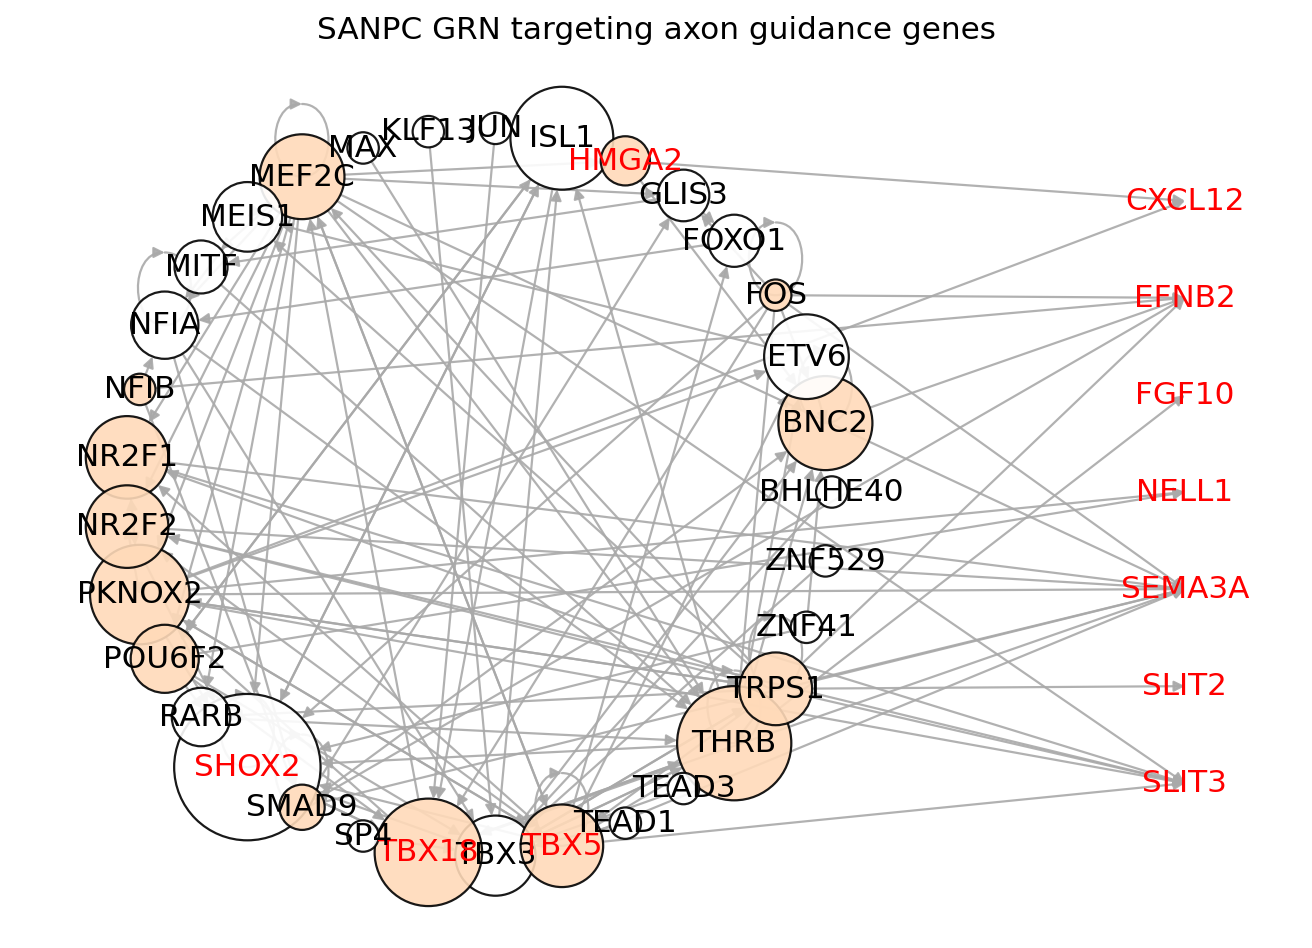

In [53]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges
for tf, targets in network.items():
    G.add_node(tf, type='TF', size=node_size_map.get(tf, 1))  # Add TF node
    for tg in targets:
        if tg not in G:
            G.add_node(tg, type='TG', size=0)  # Add TG node if not already added
        G.add_edge(tf, tg)  # Add edge

# Define tf_nodes
tf_nodes = [node for node, attr in G.nodes(data=True) if attr['type'] == 'TF']
tg_nodes = [node for node, attr in G.nodes(data=True) if attr['type'] == 'TG']
tg_nodes.sort()

# Identifying direct and indirect TFs
direct_tfs = set()
for tf, targets in network.items():
    for tg in targets:
        if tg in tg_nodes:
            direct_tfs.add(tf)

indirect_tfs = list(set(tf_nodes) - direct_tfs)  # TFs that are not in direct TFs
direct_tfs = list(direct_tfs)
indirect_tfs.sort()
direct_tfs.sort()

# Manually creating circular positions for indirect and direct TFs, and linear positions for TGs
def create_circular_positions(node_list, center_x, center_y, radius):
    angle_step = 2 * np.pi / len(node_list)
    return {node: (center_x + np.cos(i * angle_step) * radius, center_y + np.sin(i * angle_step) * radius) 
            for i, node in enumerate(node_list)}

# Create circular positions for indirect plus direct TFs
all_tfs = direct_tfs+indirect_tfs
all_tfs.sort()
tf_pos = create_circular_positions(all_tfs, 0.5, 0.5, 0.25)

# Linear positions for TGs
tg_x = [1 for _ in tg_nodes]  # All TG nodes have the same x-coordinate
tg_y = np.linspace(0.7, 0.3, len(tg_nodes))  # Evenly spaced y-coordinates
tg_pos = {tg: (x, y) for tg, x, y in zip(tg_nodes, tg_x, tg_y)}

# Combine positions
pos = {**tf_pos, **tg_pos}

# Update node colors: indirect TFs to "lightskyblue"
for node in G.nodes:
    if node in indirect_tfs:
        G.nodes[node]['color'] = 'white'
    else:
        G.nodes[node]['color'] = 'peachpuff' if G.nodes[node]['type'] == 'TF' else 'white'

# node colors
node_colors = [data['color'] for node, data in G.nodes(data=True)]

# node label colors
label_colors = dict((node,'red') if node in degs_foetal_vs_adult else (node,'black') for node in G.nodes())

# Plotting with updated positions
plt.figure(figsize=(8, 5.5))
nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=[G.nodes[node]['size'] for node in G.nodes()], 
        edge_color='darkgrey', alpha=0.9, 
        edgecolors="black", linewidths=1, node_shape="o")
# Draw labels with specified colors
for node, color in label_colors.items():
    plt.text(pos[node][0], pos[node][1], s=node, 
             bbox=dict(facecolor='white', alpha=0),
             horizontalalignment='center', verticalalignment='center',
             color=color)

plt.title("SANPC GRN targeting axon guidance genes")
plt.savefig(f"{figdir}/SANPC_GRN_Axon-guidance-genes.pdf", bbox_inches="tight",dpi=300)
plt.show()